In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import *
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import seaborn
import pandas as pd
import datetime

In [3]:
seaborn.set()

In [4]:
#cp calc path
cpath17 = "/home/chase/projects/peakload/data/ercot/fourcp2017.xlsx"
cpath18 = "/home/chase/projects/peakload/data/ercot/fourcp2018.xlsx"

cp17 = pd.read_excel(cpath17)
cp18 = pd.read_excel(cpath18)

In [6]:
cp18['Unnamed: 7'][2:-3]

2       4761.04
3       1137.44
4       136.165
5       45.9004
6       28.2019
7       452.353
8        3.9995
9       259.764
10      340.625
11      17323.4
12      138.515
13      65.9054
14      2545.94
15      2.45505
16      16.2182
17      12.7828
18      31.7285
19      16.7574
20      14.3104
21      56.4182
22      13.3448
23      18.5246
24      6.50563
25      197.908
26      20.6035
27      7.43079
28      5.52472
29      80.6227
30       32.933
31      439.076
         ...   
102     72.8839
103     282.023
104     150.586
105     25460.9
106     5.41382
107     1371.76
108     63.5239
109     11.5784
110           0
111     4.98004
112     134.305
113           0
114     41.0182
115     84.9518
116    0.069605
117           0
118     44.9116
119           0
120     65.3592
121     1766.19
122     679.652
123     185.875
124    0.108994
125     450.978
126     104.014
127     93.0144
128    0.664403
129     37.9269
130     122.782
131    0.089667
Name: Unnamed: 7, Length

In [7]:
percs17 = np.sort(cp17['Average 4CP Load'][0:-3])[::-1]/np.max(cp17['Average 4CP Load'])*100
percs18 = np.sort(cp18['Unnamed: 7'][2:-3])[::-1]/np.max(cp18['Unnamed: 7'][2:])*100

In [8]:
np.sum(percs18[0:6])

81.27025845273711

In [9]:
np.sum(percs17[0:6])

80.7150418744308

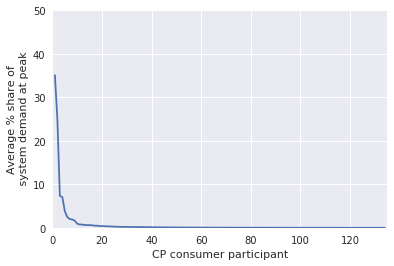

In [10]:
plt.plot(np.sort(cp17['Average 4CP Load'][0:-2])[::-1]/np.max(cp17['Average 4CP Load'])*100)
plt.xlabel("CP consumer participant")
plt.ylabel("Average % share of\n system demand at peak")
plt.ylim(0,50)
plt.xlim(0,135)
plt.show()

In [11]:
#distribution of likely cp loads
months = {1: "jan", 2: "feb", 3: "mar", 4: "apr", 5: "may", 6: "jun", 7: "jul", 8: "aug", 9: "sep", 10: "oct", 11: "nov", 12: "dec"}

startdate = datetime.datetime(year=2010, month=1, day=1, hour=0, minute=0, second=0)
curr = startdate
enddate = datetime.datetime(year=2018, month=1, day=1, hour=0, minute=0, second=0)

allhours = []

while curr < enddate:
    allhours.append(curr)
    curr += datetime.timedelta(hours=1)

In [12]:
path = "/home/chase/projects/peakload/data/ercot/"
ercot2017 = pd.read_excel(path + "native_Load_2017.xlsx") 

ercot2018 = pd.read_excel(path + "Native_Load_2018.xlsx")

In [13]:
ercot2017

,Hour Ending,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
0,01/01/2017 01:00,8791.789509,896.746302,1997.717635,683.621986,9239.153285,2366.632745,4490.781365,954.192864,29420.635691
1,01/01/2017 02:00,8569.708419,865.930568,1997.781319,677.969375,9104.997245,2332.744630,4370.656830,951.025166,28870.813551
2,01/01/2017 03:00,8326.425638,839.051175,1993.699160,671.998949,8988.035201,2237.506202,4210.650003,944.357749,28211.724078
3,01/01/2017 04:00,8137.497400,822.829332,1995.540876,675.267971,8979.148462,2178.102265,4088.713039,943.188703,27820.288047
4,01/01/2017 05:00,8011.869581,814.016188,1995.253501,663.619875,9033.547636,2133.953870,4021.757095,954.937932,27628.955677
5,01/01/2017 06:00,7978.099664,823.419356,1981.351897,669.747960,9195.157967,2122.016553,4045.300321,972.562414,27787.656130
6,01/01/2017 07:00,8057.124384,844.951107,1983.277000,684.489333,9507.347021,2146.562161,4156.665931,993.640352,28374.057289
7,01/01/2017 08:00,8125.760480,874.576030,2015.313095,710.230542,9881.595658,2137.645043,4286.082106,1019.343832,29050.546784
8,01/01/2017 09:00,8289.158421,919.260682,2008.248072,728.165596,10215.312408,2185.327013,4441.357023,1033.339042,29820.168257
9,01/01/2017 10:00,8646.523850,956.214471,2024.821254,727.770964,10566.137519,2305.297014,4604.238519,1017.389337,30848.392927


In [14]:
sorted_loads_17 = np.sort(ercot2017['ERCOT'])
CDF_17 = []
load_vals = np.arange(np.min(sorted_loads_17), np.max(sorted_loads_17), 10)
for l in load_vals:
    greater = np.sum([1 for k in sorted_loads_17 if k >= l])/float(len(sorted_loads_17))
    CDF_17.append(1.0 - greater)
                                                                   
sorted_loads_18 = np.sort(ercot2018['ERCOT'])
CDF_18 = []
load_vals = np.arange(np.min(sorted_loads_18), np.max(sorted_loads_18), 10)
for l in load_vals:
    greater = np.sum([1 for k in sorted_loads_18 if k >= l])/float(len(sorted_loads_18))
    CDF_18.append(1.0 - greater)
    
    
#greater = np.sum([1 for k in train_data_vals if k >= val])/float(len(train_data_vals))

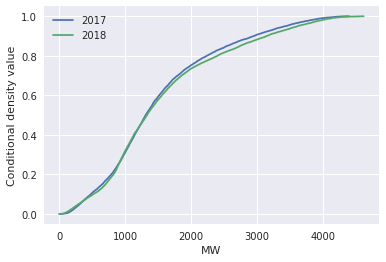

In [15]:
plt.plot(CDF_17, label="2017")
plt.plot(CDF_18, label="2018")
plt.legend()
plt.ylabel("Conditional density value")
plt.xlabel("MW")
plt.show()

In [16]:
cp17_vals = cp17['Average 4CP Load'][0:-3]
max_diff = sorted_loads_17[-1] - sorted_loads_17[-2]
less_than = np.zeros((len(cp17_vals),))
less_than_10 = np.zeros((len(cp17_vals),))

for i in range(len(cp17_vals)):
    if cp17_vals.values[i] < max_diff:
        less_than[i] = 1
    if cp17_vals.values[i] < 0.1*max_diff:
        less_than_10[i] = 1
        
print(np.mean(less_than))
print(np.mean(less_than_10))

0.6492537313432836
0.21641791044776118


In [18]:
print(max_diff)

58.19941800000379


In [19]:
cp18_vals = cp18['Unnamed: 7'][2:-3]
max_diff = sorted_loads_18[-1] - sorted_loads_18[-2]
less_than = np.zeros((len(cp18_vals),))
less_than_10 = np.zeros((len(cp18_vals),))

for i in range(len(cp18_vals)):
    if cp18_vals.values[i] < max_diff:
        less_than[i] = 1
    if cp18_vals.values[i] < 0.1*max_diff:
        less_than_10[i] = 1
        
print(np.mean(less_than))
print(np.mean(less_than_10))

print(max_diff)

0.8153846153846154
0.4076923076923077
168.6320859999978


In [20]:
len(cp18_vals)

130

In [128]:
#parse date function
def parse_pjm_date(strin):
    dt = datetime.datetime.strptime(strin, '%m/%d/%Y %H:%M:%S %p')
    return(dt)

In [129]:
#PJM peakload forecast errors
#6/1/2018 -- 9/30/2018
#DEOK Duke Energy Ohio Kentucky
#summer of 2018

path = "/home/chase/projects/peakload/data/pjm/forecasterror"
loadpath = path + "/DEOK_hrl_load_metered.csv"
forecastpath = path + "/DEOK_load_frcstd_hist.csv"

In [130]:
loadd = pd.read_csv(loadpath)
fcastd = pd.read_csv(forecastpath)

In [141]:
fcastd

,evaluated_at_utc,evaluated_at_ept,forecast_hour_beginning_utc,forecast_hour_beginning_ept,forecast_area,forecast_load_mw
0,5/31/2018 9:45:00 AM,5/31/2018 5:45:00 AM,6/1/2018 4:00:00 AM,6/1/2018 12:00:00 AM,DEOK,3243
1,5/31/2018 1:45:00 PM,5/31/2018 9:45:00 AM,6/1/2018 4:00:00 AM,6/1/2018 12:00:00 AM,DEOK,3220
2,5/31/2018 3:45:00 PM,5/31/2018 11:45:00 AM,6/1/2018 4:00:00 AM,6/1/2018 12:00:00 AM,DEOK,3203
3,5/31/2018 9:45:00 PM,5/31/2018 5:45:00 PM,6/1/2018 4:00:00 AM,6/1/2018 12:00:00 AM,DEOK,3195
4,6/1/2018 3:45:00 AM,5/31/2018 11:45:00 PM,6/1/2018 4:00:00 AM,6/1/2018 12:00:00 AM,DEOK,2899
5,5/31/2018 9:45:00 AM,5/31/2018 5:45:00 AM,6/1/2018 5:00:00 AM,6/1/2018 1:00:00 AM,DEOK,3027
6,5/31/2018 1:45:00 PM,5/31/2018 9:45:00 AM,6/1/2018 5:00:00 AM,6/1/2018 1:00:00 AM,DEOK,3008
7,5/31/2018 3:45:00 PM,5/31/2018 11:45:00 AM,6/1/2018 5:00:00 AM,6/1/2018 1:00:00 AM,DEOK,2989
8,5/31/2018 9:45:00 PM,5/31/2018 5:45:00 PM,6/1/2018 5:00:00 AM,6/1/2018 1:00:00 AM,DEOK,2983
9,6/1/2018 3:45:00 AM,5/31/2018 11:45:00 PM,6/1/2018 5:00:00 AM,6/1/2018 1:00:00 AM,DEOK,2721


In [142]:
fcastdates = fcastd['forecast_hour_beginning_ept']
fcasts = fcastd['forecast_load_mw']

In [143]:
loaddates = loadd['datetime_beginning_ept']
loads = loadd['mw']

In [144]:
len(loads), len(fcasts)

(2928, 21960)

In [150]:
data = {}

for i in range(len(fcasts)):
    date = parse_pjm_date(fcastdates[i])
    data[date] = [fcasts[i]]
    
for date in data:
    data[date] = [np.mean(data[date])]
    
for i in range(len(loads)):
    date = parse_pjm_date(loaddates[i])
    if date in data:
        data[date].append(loads[i])

In [155]:
ls = []
fs = []

for date in data:
    ls.append(data[date][-1])
    fs.append(data[date][0])

In [197]:
fs_g = np.array([fs])
ls_g = np.array([ls])

fs_ = fs_g[fs_g > 4700]
ls_ = ls_g[fs_g > 4700]

print(len(fs_)/len(fs)), print(len(fs_g))

0.09289617486338798
1


(None, None)

In [198]:
errors = fs_ - ls_
print(errors)

[ 9.98030e+01  5.75440e+01  5.62890e+01 -2.38630e+01 -5.53220e+01
 -5.52670e+01 -1.72020e+01  9.66400e+00 -4.76000e-01  6.50940e+01
 -2.30510e+01  1.55770e+01 -1.06797e+02 -2.12815e+02 -2.49607e+02
  5.69560e+01  3.87280e+01  6.54860e+01  9.42050e+01  1.31507e+02
  4.02480e+01 -1.48000e-01  4.41680e+01 -1.27634e+02 -1.51179e+02
 -1.34790e+01 -3.49000e-01  3.67020e+01 -5.46580e+01 -1.17679e+02
  7.15650e+01  5.22340e+01  2.53970e+01  1.49570e+01 -3.80660e+01
  2.99879e+02  4.82660e+01  3.39249e+02  4.67940e+01  7.49990e+01
  2.52034e+02  2.05280e+01  2.16720e+01 -3.59100e+00 -3.50000e-01
  6.42520e+01  1.26185e+02 -4.99550e+01 -7.94970e+01  3.62540e+01
 -3.72050e+01  2.96800e+00  4.07870e+01  1.50290e+02  2.50126e+02
 -2.73450e+01 -1.09568e+02 -1.41700e+02 -2.59194e+02 -2.66241e+02
 -1.80950e+01 -1.34207e+02 -9.63110e+01  5.93170e+01  4.55150e+01
 -3.09710e+01 -1.14420e+01  2.64610e+01  3.44200e+00 -7.26200e+00
  5.24400e+01 -4.44480e+01 -1.26450e+01  1.06210e+01 -3.24840e+01
  1.37944e

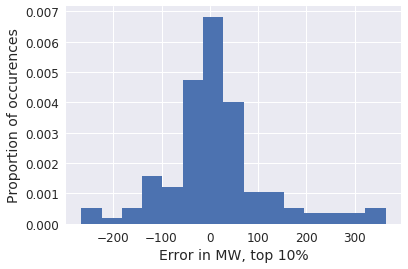

In [203]:
plt.hist(errors, bins=15, normed=True)
#plt.title("Forecast error")
plt.xlabel("Error in MW, top 10%", fontsize=14)
plt.ylabel("Proportion of occurences", fontsize=14)
plt.tick_params(labelsize=12)
plt.show()

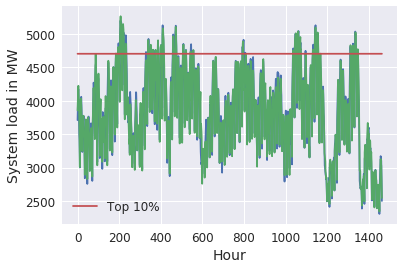

In [205]:
plt.plot(ls)
plt.plot(fs)
plt.plot([4700 for i in range(len(fs))], label="Top 10%")
plt.ylabel("System load in MW", fontsize=14)
plt.xlabel("Hour", fontsize=14)
plt.tick_params(labelsize=12)
plt.legend(fontsize=12)
plt.show()

2502.8920000000003